In [1]:
class RandomStrategy:
    def learn(self,k, result):
        return

    def choice(self):
        return random.randrange(MultiArmedBandit.NUM);

    def reset(self):
        return



In [2]:
import numpy as np

def OnePlay(numplay, strategies, mab, change=False):
    '''ndarray として返す。'''
    myaccounts = np.zeros(len(strategies), dtype=int)
    for x in strategies:
        x.reset()

    for i in range(numplay):
        for s in range(len(strategies)):
            k = strategies[s].choice() 
            result = mab.slot(k)   
            myaccounts[s] += result 
            strategies[s].learn(k,result)  
        if(change):
            mab.update()  # 確率が変化していく場合
    return(myaccounts/numplay)  

def MultiMABTester(n, strategies, change=False):
    NUMPLAY = 10000
    ret = np.zeros((len(strategies),0))
    print(ret.shape)
    
    for i  in range(n):
        mab = MultiArmedBandit()
        ret = np.append(ret, OnePlay(NUMPLAY, strategies, mab, change).reshape(len(strategies),1), axis=1)
    return ret


In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def MABTest(numplay, strategy, mab, change=False):
    '''numplay 回数だけ，str ストラテジーで mab multi-armed bandit 
    から引いて当たった回数を表示する'''
    total = [0]*10
    atari = [0]*10
    myaccount = 0
    for i in range(numplay):
        k = strategy.choice();   # str に聞いて
        result = mab.slot(k);   # 言われたスロットをひいて
        total[k] += 1
        atari[k] += result
        myaccount += result;    # 結果だけ account を増やす (0 か 1)
        strategy.learn(k,result);     #k を引いて結果が result だったことを str に学習させる
        if(change):
            mab.update()   # 確率を毎回変化させるには，このコメントをはずす。
    print(f"{numplay} 中 {myaccount}回あたり")   

    fig, ax1 = plt.subplots()
    ax1.plot([x.p for x in mab.bandits], color="red")
    ax1.set_ylim(0,1)
    ax2 = ax1.twinx()  # 2つのプロットを関連付ける
    ax2.plot(atari)
    ax2.plot(total)
    ax2.set_ylim(0,10000)
#        print([f"{x.p:2.2}" for x in m.bandits])
#    print([f"{atari[x]:4}" for x in range(10)])
#    print([f"{total[x]:4}" for x in range(10)])

In [4]:
class TsuikiStrategy:
    def __init__(self):
        self.my = 0
    def learn(self, k, result):
        if (result == 1):
            self.my = self.my;
        else:
            self.my = (self.my + 1)% MultiArmedBandit.NUM

    def choice(self):
        return self.my

    def reset(self):
        self.my = 0

In [5]:
import random
class Bandit:
    '''スロットマシン  確率 p で  1, 1-p で 0 を返す （ベルヌーイ分布）'''
    def __init__(self):
        self.p = random.uniform(0,1)

    def slot(self):
        if (random.uniform(0,1) <  self.p):
            return 1
        else:
            return 0

    def update(self):
        '''1/2 の確率で，0.05 上げるか下げるか。 \
        0 または 1 になったらそれ以上は動かさない。'''
        if(random.uniform(0,1) < 0.5):
            self.p = max(self.p - 0.05, 0)
        else:
            self.p = min(self.p + 0.05, 1)

class MultiArmedBandit:
    NUM= 10;   #スロットマシンの個数
    def __init__(self):
        self.bandits = [Bandit() for i in range(MultiArmedBandit.NUM)]

    def slot(self,i):
        '''i 番目のスロットマシンを引く'''
        if (i < 0 or i >= MultiArmedBandit.NUM):
            return 0
        return self.bandits[i].slot()

    def update(self):
        '''全ての確率を更新。今は使用しない。'''
        for b in self.bandits:
            b.update()

    def getmax(self):
        return max([x.p for x in self.bandits])


In [9]:
import matplotlib.pyplot as plt
import random

class AoyagiStrategy:
    '''pの最尤推定値が最も高いスロットマシンを引く
    とりあえず、各スロットをnumplayの1/100ずつ回してそれをモデルとする
    str=AoyagiStrategy(10000)みたいな感じで使ってください'''
    def __init__(self,numplay = 10000):
        self.my=0#現時点のスロット番号
        self.times=[0 for i in range(MultiArmedBandit.NUM)]#それぞれを回した回数
        self.hit=[0 for i in range(MultiArmedBandit.NUM)]#それぞれで当てた回数
        self.like_p=[0 for i in range(MultiArmedBandit.NUM)]#それぞれのｐの最尤推定値
        self.num=int(numplay/100)#モデルデータの個数
    def learn(self,k,result):
        if self.times[k]<self.num:#データ数未満の時
            if result==1:
                self.hit[k]+=1
        elif self.times[k]==self.num:#データ数と等しいとき
            self.like_p[k]=self.hit[k]/self.times[k]
            if self.my<9:
                self.my=(self.my+1)%MultiArmedBandit.NUM
            else:
                self.my=self.like_p.index(max(self.like_p))
        self.times[k]+=1
    def choice(self):
        return self.my
    def reset(self):
        self.my=0
        

class EtoriStrategy:
    def __init__(self):
        self.etori = 0
        self.etotal = [2]*10
        self.eatari = [1]*10
        self.kakuritu = [1/2]*10
        self.josoku = [0]*10
        
    def learn(self, k, result):
        from scipy.stats import norm
        import random
        self.etotal[k] += 1
        self.eatari[k] += result
        self.kakuritu[k] = (self.eatari[k])/(self.etotal[k])
        for i in range(10):
            a=self.kakuritu[i]
            b=self.etotal[i]
            self.josoku[i] = norm.sf(x=max(self.kakuritu), loc=a, scale=((a*(1-a))/b)**(1/2))
        self.etori = random.choices([0,1,2,3,4,5,6,7,8,9] , weights=self.josoku)[0]
            
    def choice(self):
        return self.etori

    def reset(self):
        self.etori = 0
        self.etotal = [2]*10
        self.eatari = [1]*10
        self.kakuritu = [1/2]*10
        self.josoku = [0]*10

class HiranoStrategy:
    def __init__(self):
        self.my = 0
        self.count = 0
        self.box =[]
        for _ in range(MultiArmedBandit.NUM):
            self.box.append([])
        self.blocklist =[0,0,0,0,0,0,0,0,0,0]
        self.check = 0

    def learn(self, k, result):
        
        self.box[k].append(result)
        
        if len(self.box[k]) == 2 and self.box[k] == [0,0]:
            self.blocklist[k] = 1
        elif len(self.box[k]) == 4 and self.box[k].count(0) == 3:
            self.blocklist[k] = 1
        elif len(self.box[k]) >= 6 and self.box[k].count(1)/len(self.box[k]) < 0.5:
            self.blocklist[k] = 1
        elif self.count == 100:
            l = []
            for i in range(MultiArmedBandit.NUM):
                l.append(self.box[i].count(1)/(len(self.box[i]) + 0.01))     
            p = 0
            q = 0
            for i in range(len(l)):
                if l[i] >= l[p]:
                    q = p
                    p = i
                elif l[i] >= l[q]:
                    q = i
            self.blocklist = [1,1,1,1,1,1,1,1,1,1]
            self.blocklist[p] = [0]
            self.blocklist[q] = [0]
        elif self.count == 500:
            l = []
            for i in range(MultiArmedBandit.NUM):
                l.append(self.box[i].count(1)/(len(self.box[i]) + 0.01))     
            p = 0
            for i in range(len(l)):
                if l[i] >= l[p]:
                    p = i
            self.blocklist = [1,1,1,1,1,1,1,1,1,1]
            self.blocklist[p] = [0]
            
        if self.blocklist.count(1) == 10:
            l = []
            for i in range(MultiArmedBandit.NUM):
                l.append(self.box[i].count(1)/len(self.box[i]))     
            p = 0
            q = 0
            for i in range(len(l)):
                if l[i] >= l[p]:
                    q = p
                    p = i
                elif l[i] >= l[q]:
                    q = i
            self.blocklist = [1,1,1,1,1,1,1,1,1,1]
            self.blocklist[p] = [0]
            self.blocklist[q] = [0]
            
        if (result == 1):
            self.count += 1
            self.my = self.my;
        else:
            self.count += 1
            self.my = (self.my + 1)% MultiArmedBandit.NUM
            while self.blocklist[self.my] == 1:
                self.my = (self.my + 1)% MultiArmedBandit.NUM
            
    def choice(self):
        return self.my

    def reset(self):
        self.blocklist =[0,0,0,0,0,0,0,0,0,0]
        

class IkedaStrategy:
    def __init__(self):
        self.chcount = 0
        self.my = 0
        # 結果を格納
        self.results = [0 for i in range(10)]

    def learn(self, k, result):
        self.chcount += 1
        # 100回ずつ引いて確率の高いものを引き続けます. 100回ごと再判定します.
        if self.chcount < 1000:
            self.my = self.chcount // 100
            self.results[k] += result
        elif self.chcount == 1000:
            maxres = max(self.results)
            maxidx = self.results.index(maxres)
            self.results[maxidx] = 0
            self.my = maxidx
        elif self.chcount % 100 == 0:
            self.results[k] += result
            maxres = max(self.results)
            maxidx = self.results.index(maxres)
            self.results[maxidx] = 0
            self.my = maxidx
        else:
            self.results[k] += result

    def choice(self):
        return self.my

    def reset(self):
        self.__init__()

class KasuyaStrategy:
    learnNum = 340 #台数の倍数にする必要あり
    
    def __init__(self):
        self.my = 0 #どの番号の台から引くか
        self.nowPlay = 0 #今の思考回数
        self.nowLearn = True 
        self.learnAry = np.zeros(10, dtype=int)
        self.my = 0
    
    def learn(self,k, result):
        self.nowPlay += 1
        if self.nowLearn == True:
            self.learnAry[k] += result
            if self.nowPlay >= KasuyaStrategy.learnNum: #learnを終えたら
                self.my = np.argmax(self.learnAry) #learnAryの最大値を取る台
                self.nowLearn = False
            

    def choice(self):
        if self.nowLearn == True:
            return self.nowPlay%10 #learn中
        return self.my #learn後

    def reset(self):
        self.my = 0
        self.nowPlay = 0
        self.nowLearn = True
        self.learnAry = np.zeros(10, dtype=int)
        self.my = 0# 薬学部3年 本岡響

class MotookaStrategy:
    def __init__(self):
        self.next = 0          #次に選ぶマシン
        self.trial = [True]*10 #パターンを変えた時に選ぶかどうか
        self.cnt = [0]*10      #何回選んだか
        self.okcnt = [0]*10    #何回当たったか
        self.rate = [0]*10     #okcnt/cnt。cntがゼロなら0。
        self.incnt = 0         #何回試行したか
        self.nmin = 2000       #パターンを変える閾値
        self.nrange = 6        #小さい方から何個サヨナラするか
    def learn(self,k,result):
        self.incnt += 1
        self.cnt[k] += 1
        self.okcnt[k] += result
        if self.incnt < self.nmin:
            # とりあえずnmin回はやる
            self.next = (self.next + (1-result))% MultiArmedBandit.NUM
            return
        if (self.incnt >= self.nmin) and (self.incnt < (self.nmin + self.nrange)):
            # 小さい方から順にnrange個、順番にサヨナラ
            for i in range(MultiArmedBandit.NUM):
                if self.cnt[i] == 0:
                    self.rate[i] == 0
                else:
                    self.rate[i] = self.okcnt[i] / self.cnt[i]
            minban = 1.0
            for i in range(MultiArmedBandit.NUM):
                if self.trial[i]:
                    minban = min(minban, self.rate[i])
            ch = 0
            for i in range(MultiArmedBandit.NUM):
                if self.rate[i]:
                    ch += 1
            for i in range(MultiArmedBandit.NUM):
                if ch == 1:
                    break
                if self.rate[i] <= minban:
                    self.trial[i] = False # もう選ばない
                    ch -= 1
        
        self.next = (self.next + (1-result))% MultiArmedBandit.NUM
        times = 0
        while not self.trial[self.next]:
            if times >= 10:
                break
            # self.trialがFalseのマシンは二度と選ばない
            self.next = (self.next + 1)% MultiArmedBandit.NUM
            times += 1
        return
    def choice(self):
        return self.next
    def reset(self):
        self.next = 0

class OshimaStrategy:
    """最初に各TEST_NUM回ずつそれぞれのスロットを回す。MAB.NUM * TEST_NUM回試した後は、最も当たりのよく出たスロットを引き続ける。"""
    """理学部1回 大島直也"""
    def __init__(self, TEST_NUM = 10):
        self.i = 0
        self.memory = [0] * MultiArmedBandit.NUM
        self.testnum = TEST_NUM
    
    def choice(self):
        if self.i <= MultiArmedBandit.NUM * self.testnum:
            return self.i % MultiArmedBandit.NUM
        else:
            return np.argmax(self.memory)
    
    def learn(self, k, result):
        self.i += 1
        self.memory[k] += result
        return
    
    def reset(self):
        self.i = 0
        self.memory = [0] * MultiArmedBandit.NUM
        self.testnum = 10

class TSUKAMOTOStrategy:
    def __init__(self):    
        self.ctls = [0]*10
        self.i=0
    def learn(self, k, result):
        if (result == 1):
            self.ctls[k] = self.ctls[k] +1
        else:
            return

    def choice(self):
        if (self.i<1000):
            self.i=self.i+1
            return self.i-1 % MultiArmedBandit.NUM
        elif (self.i<1500):
            self.i=self.i+1
            maxls = sorted(self.ctls, reverse=True)[:3]
            maxi = [0]*3
            j=0
            l=0
            while (j<3):
                if ((self.ctls[l] in maxls)==True):
                    maxi[j]=l
                    j=j+1
                l=l+1
            return maxi[((self.i) % 3 -1)]
        else:
            mx=max(self.ctls)
            j=-1
            l=0
            while (j==-1):
                if (self.ctls[l]==mx):
                    j=l
                l=l+1
            return j
    
    def reset(self):
        return

class UyamaStrategy:
    CountST = 800
    
    def __init__(self):
        self.my = 0
        self.count = 0
        self.li = [0]*MultiArmedBandit.NUM
        
    def learn(self, k, result):
        self.my = (self.my + 1)% MultiArmedBandit.NUM
        self.count += 1
        if (result == 1):
            self.li[k] += 1
            
    def choice(self):
        if self.count <= self.CountST:
            return self.my
        
        else:
            return self.li.index(max(self.li))
        
    def reset(self):
        self.my = 0
        self.count = 0
        self.li = [0]*MultiArmedBandit.NUM



(11, 0)


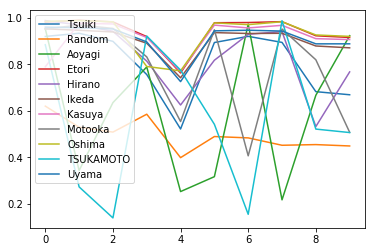

In [10]:
names = ["Tsuiki", "Random", "Aoyagi", "Etori",
        "Hirano", "Ikeda", "Kasuya", "Motooka", 
        "Oshima", "TSUKAMOTO", "Uyama"]
ret = MultiMABTester(10, [TsuikiStrategy(),
                          RandomStrategy(),
                        AoyagiStrategy(),
                          EtoriStrategy(),
                        HiranoStrategy(),
                          IkedaStrategy(),
                          KasuyaStrategy(),
                          MotookaStrategy(),
                          OshimaStrategy(),
                          TSUKAMOTOStrategy(),
                          UyamaStrategy()
                         ])
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
for i in range(len(names)):
    plt.plot(ret[i], label=names[i])
# rs は、red, square
plt.legend(loc='upper left')

sorted(zip(list(map(sum,ret)), names))


In [22]:
sorted(zip(list(map(sum,ret)), names))


[(4.9756, 'Random'),
 (5.7097, 'TSUKAMOTO'),
 (6.0739, 'Aoyagi'),
 (7.8969, 'Motooka'),
 (8.0915, 'Tsuiki'),
 (8.3267, 'Hirano'),
 (9.0236, 'Ikeda'),
 (9.1016, 'Uyama'),
 (9.133299999999998, 'Kasuya'),
 (9.2968, 'Oshima'),
 (9.416, 'Etori')]